# MIE1624 Assginment 2

the ideas of having ourlier detection and feature importance ordering has been discussed with SUTING YANG.<br>
the code and report are solely done by myself.<br>
corresponding reference for some plotting has been cited when using.

In [2]:
# import

import warnings

# construct dataframe, computing
import pandas as pd
import numpy as np

# feature selection class
from feature_selector import FeatureSelector
from sklearn.feature_selection import mutual_info_regression

#
from sklearn.model_selection import train_test_split, cross_val_score,KFold,GridSearchCV
from sklearn.feature_selection import SelectFromModel,RFE
from sklearn.linear_model import Ridge, RidgeCV, ElasticNet, LassoCV, Lasso, LassoLarsCV,LinearRegression
from sklearn.metrics import make_scorer, r2_score, mean_squared_error, auc, mean_absolute_error
from sklearn.neighbors import KNeighborsRegressor
from sklearn.ensemble import RandomForestRegressor,GradientBoostingRegressor
from lightgbm import LGBMRegressor

# plot
import seaborn as sns
import matplotlib.pyplot as plt

E:\Applications\Anaconda3\lib\site-packages\sklearn\ensemble\weight_boosting.py:29: DeprecationWarning: numpy.core.umath_tests is an internal NumPy module and should not be imported. It will be removed in a future NumPy release.
  from numpy.core.umath_tests import inner1d


In [2]:
# load and demo of the data
data_raw_df = pd.read_csv("Kaggle_Salary.csv", low_memory=False)

In [3]:
data_raw_df.head()

,Unnamed: 0,Time from Start to Finish (seconds),Q1,Q1_OTHER_TEXT,Q2,Q3,Q4,Q5,Q6,Q6_OTHER_TEXT,...,Q50_Part_1,Q50_Part_2,Q50_Part_3,Q50_Part_4,Q50_Part_5,Q50_Part_6,Q50_Part_7,Q50_Part_8,Q50_OTHER_TEXT,index
0,0,Duration (in seconds),What is your gender? - Selected Choice,What is your gender? - Prefer to self-describe...,What is your age (# years)?,In which country do you currently reside?,What is the highest level of formal education ...,Which best describes your undergraduate major?...,Select the title most similar to your current ...,Select the title most similar to your current ...,...,What barriers prevent you from making your wor...,What barriers prevent you from making your wor...,What barriers prevent you from making your wor...,What barriers prevent you from making your wor...,What barriers prevent you from making your wor...,What barriers prevent you from making your wor...,What barriers prevent you from making your wor...,What barriers prevent you from making your wor...,What barriers prevent you from making your wor...,NaN
1,2,434,Male,-1,30-34,Indonesia,Bachelor’s degree,Engineering (non-computer focused),Other,0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-1,0.0
2,3,718,Female,-1,30-34,United States of America,Master’s degree,"Computer science (software engineering, etc.)",Data Scientist,-1,...,NaN,Too time-consuming,NaN,NaN,NaN,NaN,NaN,NaN,-1,1.0
3,5,731,Male,-1,22-24,India,Master’s degree,Mathematics or statistics,Data Analyst,-1,...,NaN,Too time-consuming,NaN,NaN,Not enough incentives to share my work,NaN,NaN,NaN,-1,2.0
4,7,959,Male,-1,35-39,Chile,Doctoral degree,"Information technology, networking, or system ...",Other,1,...,Too expensive,NaN,NaN,NaN,NaN,I had never considered making my work easier f...,NaN,NaN,-1,3.0


## 1. Data cleaning

### 1.1 select proper data subset (handle outliers)
#### According to the instruction, a subset of the dataset is allowed to be selected out for the assignment. <br>We could have a look at the data distribution first.

In [4]:
# drop the first row that explains each feature(name), we do not need it for the moment
data_raw_df = data_raw_df.drop(data_raw_df.index[[0]]).reset_index(drop=True)

data_raw_df['Q9'] = data_raw_df['Q9'].astype(int)
target_df = data_raw_df['Q9']

E:\Applications\Anaconda3\lib\site-packages\scipy\stats\stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


<function matplotlib.pyplot.show(*args, **kw)>

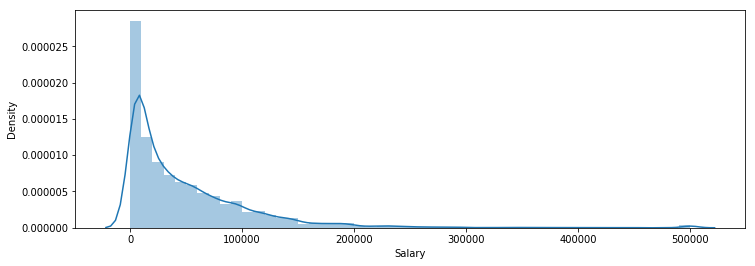

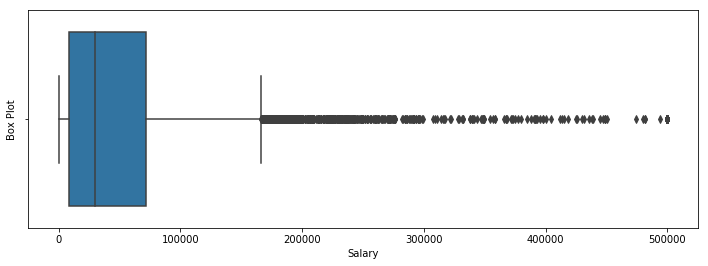

In [5]:
# we first have a look at the data density distribution
plt.figure(figsize=(12,4))
ax = sns.distplot(target_df.values)
ax.set_xlabel('Salary')
ax.set_ylabel('Density')
#plt.axvline(10000)
plt.show

plt.figure(figsize=(12,4))
ax = sns.boxplot(target_df.values)
ax.set_xlabel('Salary')
ax.set_ylabel('Box Plot')

plt.show

#### By briefly looking at the distribution of the data, the dataset is exceptionally right-skewed. Having 15429 entries of data, with a minimum of 3-dollar annual income and a maximum of 500,000-dollar yearly salary, the dataset has been decided to be chunked properly to reflect normal life.

In [6]:
target_df.describe()

count     15429.000000
mean      50624.790265
std       62272.396495
min           3.000000
25%        8694.000000
50%       29861.000000
75%       71742.000000
max      500000.000000
Name: Q9, dtype: float64

#### Here I used a modified Tukey method (Tukey JW., 1977) to help select a section of dataset that excludes mainly lower outliers. 
* **We included only starts from 25 percentail to 75 percentail+1.5* Interquartile Range.** 
* **This is because the distribution is too right-skewed, normal Tukey method could apply on normal distribution well but we need to do according modifications, if lower bound to be set to be Q1-1.5IQR <0**
* **The trimmed dataset contains 10877 entries with minimum 8695-dollar annual income and 166297-dollar annual income.**

In [7]:
# Tukey method (Tukey JW., 1977)
# 1st quartile (25%)
Q1 = np.percentile(data_raw_df['Q9'], 25)
# 3rd quartile (75%)
Q3 = np.percentile(data_raw_df['Q9'],75)
# Interquartile range (IQR)
IQR = Q3 - Q1
# outlier step
outlier_step = 1.5 * IQR
# modified range
data_raw_df = data_raw_df[(data_raw_df['Q9'] > Q1 ) & (data_raw_df['Q9'] < Q3 + outlier_step )].reset_index()

# trimmed data 
target_df = data_raw_df['Q9']
target_df.describe()

count     10877.000000
mean      54084.414361
std       38156.418371
min        8695.000000
25%       21926.000000
50%       44649.000000
75%       78040.000000
max      166297.000000
Name: Q9, dtype: float64

### 1.2 drop obvious irrelvant features

In [8]:
# drop the colum(s) with unname column name (the first column)
data_raw_df = data_raw_df.loc[:, ~data_raw_df.columns.str.contains('^Unnamed')]

# drop the columns that having all the value of -1, it's been noticed that all column name ends with OTHER_TEXT will have it
# we used another way to drop columns that having value condition, samiliar as the method above
data_raw_df = data_raw_df[data_raw_df.columns.drop(list(data_raw_df.filter(regex='OTHER_TEXT')))]

# now we selectively drop the columns that we think is not important (eg: time to finish the survey)
# Q9 is meant to be dropped since it is target variable
columns_to_drop = ['Time from Start to Finish (seconds)', 'index', 'Q9', 'level_0',
                   'Q12_Part_1_TEXT', 'Q12_Part_2_TEXT', 'Q12_Part_3_TEXT', 'Q12_Part_4_TEXT', 'Q12_Part_5_TEXT']

data_raw_df['Q9'] = data_raw_df['Q9'].astype(int)
target_df = data_raw_df['Q9']
data_clean_df = data_raw_df.drop(columns_to_drop, axis=1)

### 1.3 handle missing data and categorical variables in Predictive Modeling
* **there are few missing values were due to survey takers did not answer the corresponding questions, majority of the missing values were due to the choice-way survey conducted. For example, if a survey taker chooses "python" in the given 5 machine learning coding platform, the csv file will return missing values for all other unchosen choices.**
* **One-hot encoding (Dummy coding) converts categorical input variables into continuous variables. Presence of a level is represent by 1 and absence is represented by 0. For every level present, one dummy variable will be created. It is better comparing with Label encoding in this assignment as the result is binary rather than ordinal and that everything sits in an orthogonal vector space.**
 * eg: for label encoding, if labeling [CHINA, USA, UK] as [1, 2, 3], we clearly notice the average of CHINA and UK is not USA.
* **Specifically, we fill the missing values with a certain value "missing", convert the features via one-hot encoding, then delete all columns that named "missing".**

In [9]:
# now we fill the missing values with a certain value (e.g. "missing") and completely remove the features in the next step
data_clean_df = data_clean_df.fillna('missing')

# to convert categorical input variables into counting variables via one-hot encoding
data_dummy_df = pd.get_dummies(data_clean_df)

# now we remove the features of "missing" since they are not useful
data_final_df = data_dummy_df.loc[:, ~data_dummy_df.columns.str.contains('missing')]

**Now we can see there are no missing value in the final dataframe with all categorical features converted into numerical ones**

In [10]:
# we can see the final dataframe has no missing value
data_final_df.isnull().sum().sum()

0

In [11]:
data_final_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10877 entries, 0 to 10876
Columns: 1645 entries, Q1_Female to Q50_Part_8_Other
dtypes: uint8(1645)
memory usage: 17.1 MB


### 1.4 Split Train and Test data
**We want to split the train and test data at this point. The following EDA, Feature Selection,and Modelling will be all based on train data, until we find the optimal model to test on our test data. This fits the real world situation that we should never touch test data(unseen) until the last step.**

In [12]:
X_train, X_test, y_train, y_test = train_test_split(data_final_df, target_df, test_size=0.3)

## 2. Exploratory data analysis 

### 2a) Present 3 graphical figures that represent trends in the data.

In [13]:
# in this section, we will use our cleaned but un-dommnized data fro visulization
visual_target = target_df.loc[X_train.index]
visual_train = data_clean_df.loc[X_train.index]
visual_df = visual_train.join(visual_target)

In [14]:
# we pre-set some order for age and education in order to ovbserve trend better
order_age = ['18-21','22-24','25-29','30-34','35-39','40-44','45-49','50-54','55-59','60-69','70-79','80+']
order_edu = ['Bachelor’s degree','Master’s degree','Doctoral degree','Some college/university study without earning a bachelor’s degree','No formal education past high school','Professional degree','I prefer not to answer']

### 2a)_1 Exploration with Age Group

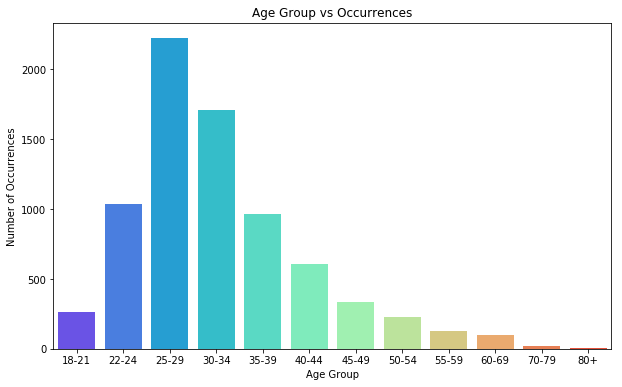

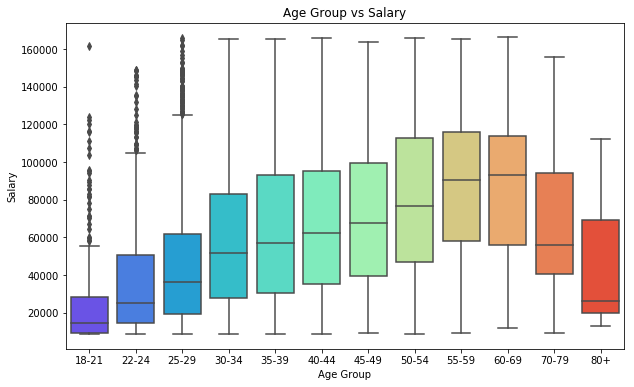

In [15]:
plt.figure(figsize=(10,6))
ax = sns.countplot(x='Q2',
                   data=visual_df,
                   palette='rainbow',
                   order = order_age)
ax.set_xlabel('Age Group')
ax.set_ylabel('Number of Occurrences')
ax.set_title('Age Group vs Occurrences')
plt.show()

plt.figure(figsize=(10,6))
ax = sns.boxplot(x='Q2',
            y='Q9',
            data=visual_df,
            palette='rainbow',
            order = order_age)
ax.set_xlabel('Age Group')
ax.set_ylabel('Salary')
ax.set_title('Age Group vs Salary')
plt.show()

**For the Age Group, we plot the relationship for it between the number of occurrences, Salary, respectively. We will be mainly forcus on the Age vs Salary boxplot, the Age vs Number of Occurrences histogram is for supporing better understanding.**
 * **From histogram(diagram 1), we could easily see number of people taking the survey is highest in 25-29 year-old population, then having a decline gradually.**
 * **From boxplot(diagram 2), we could see, before age 70, average salary increases with increase of age.**
  * Average salary decreases as aging over 70
  * There are many outliers in age groups 18-21, 22-24, 25-29.
  
**Therefore, age is thought to be an important feature for salary with noticable trend --> the elder, the richer(dont be too old).**

### 2a)_2 Exploration with Highest Education

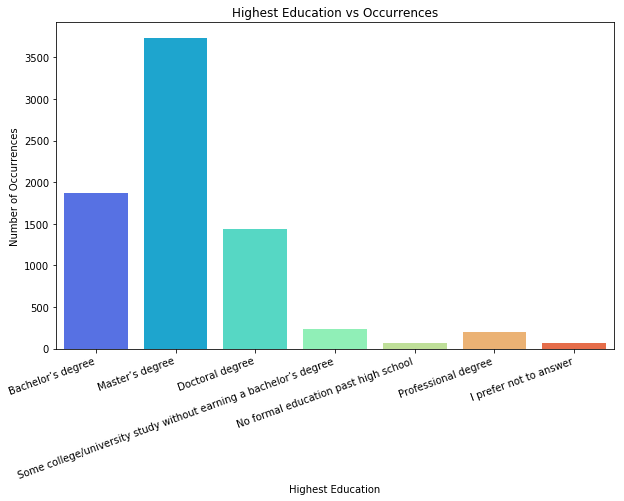

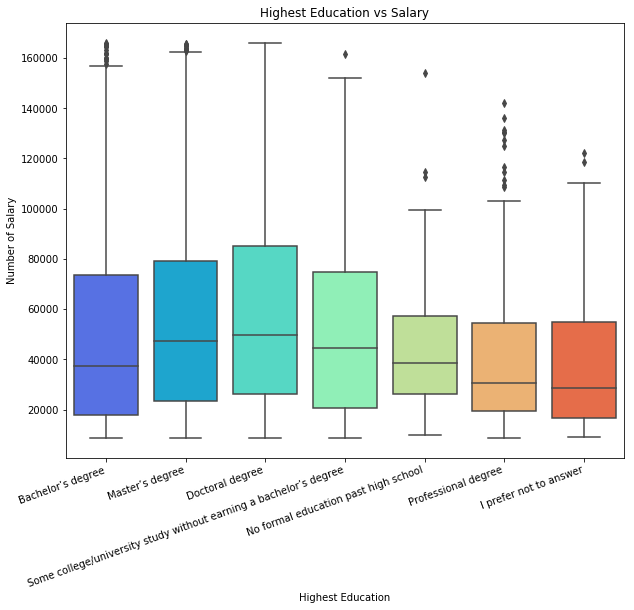

In [16]:
plt.figure(figsize=(10,6))
ax = sns.countplot(x='Q4',
                   data=visual_df,
                   palette='rainbow',
                   order = order_edu)
ax.set_xticklabels(ax.get_xticklabels(), rotation=20, ha="right")
ax.set_xlabel('Highest Education')
ax.set_ylabel('Number of Occurrences')
ax.set_title('Highest Education vs Occurrences')
plt.show()

plt.figure(figsize=(10,8))
ax = sns.boxplot(x='Q4',
                 y='Q9',
                 data=visual_df,
                 palette='rainbow',
                 order = order_edu)
ax.set_xticklabels(ax.get_xticklabels(), rotation=20, ha="right")
ax.set_xlabel('Highest Education')
ax.set_ylabel('Number of Salary')
ax.set_title('Highest Education vs Salary')
plt.show()

**For the Highest Education, we plot the relationship for it between the number of occurrences, Salary, respectively. We will be mainly forcus on the Highest Education vs Salary boxplot, the Highest Education vs Number of Occurrences histogram is for supporing better understanding.**
 * **From histogram(diagram 1), we could easily the majority people taking the survey has a bachelor or higher degree, and people having Masters degree account the most, we will then focus on these three kinds of high educated groups.**
 * **From boxplot(diagram 2), we could see, for the average salary, among high educated groups, Doctoral has the highest salary, Master's has the second highest average salary. We could say as the highest degree goes higher, average salary increases.**
  * people without high degree's highest salary is less than those having high degrees.
  * There outliers for Bachelor's degrees.
  
**Therefore, highest education is thought to be an important feature for salary with noticable trend --> higher the degree, higher the salary.**

### 2a)_3 Exploration with Current Role

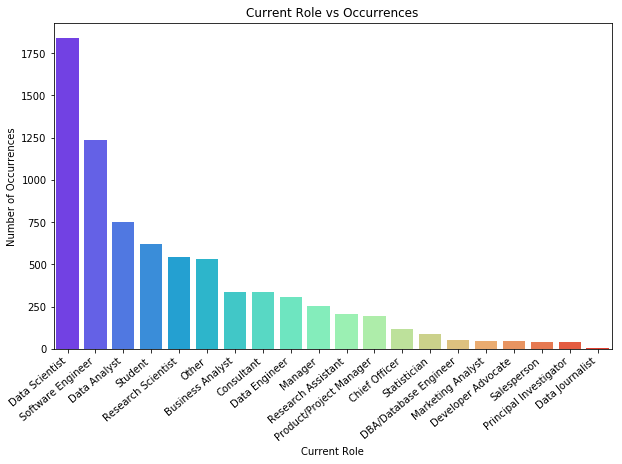

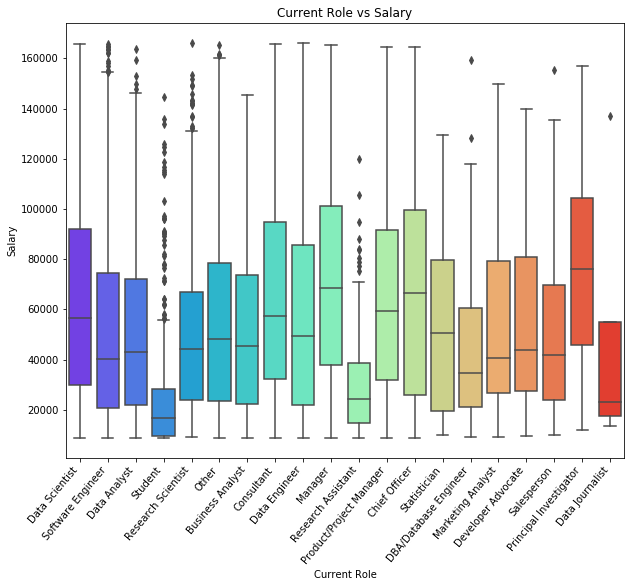

In [17]:
plt.figure(figsize=(10,6))
ax = sns.countplot(x='Q6',
                   data=visual_df,
                   palette='rainbow',
                   order = visual_df['Q6'].value_counts().index)
ax.set_xticklabels(ax.get_xticklabels(), rotation=40, ha="right")
ax.set_xlabel('Current Role')
ax.set_ylabel('Number of Occurrences')
ax.set_title('Current Role vs Occurrences')
plt.show()

plt.figure(figsize=(10,8))
ax = sns.boxplot(x='Q6',
                 y='Q9',
                 data=visual_df,
                 palette='rainbow',
                 order = visual_df['Q6'].value_counts().index)
ax.set_xticklabels(ax.get_xticklabels(), rotation=50, ha="right")
ax.set_xlabel('Current Role')
ax.set_ylabel('Salary')
ax.set_title('Current Role vs Salary')
plt.show()

**For the Current Role, we plot the relationship for it between the number of occurrences, Salary, respectively. We ranked the number of each role before ploting the first Current Role vs Number of people histogram in order to help observe trend.**
 * **From histogram(diagram 1), we could see Data Scientist, Software Engineer, Data Analyst, participate the survey the most. Relatively fewer managers and officiers took the survey.**
 * **From boxplot(diagram 2), we could see, the average salary for top 3 most survey takers are not high. In contrast, average salary for managers and officiers are much higher.**
  * Noteworthy, student and research assistant groups have really low average with many outliers, this should be considered during feature selection and testing. Because, indeed, student has no/low income no matter what other feature they have.
  
**Therefore, current role should also be an import feature(features after one-hot encoding) for modelling.**

### 2b) Visualize the order of feature importance. Some possible methods include correlation plot, or a similar method. Given the data, which of the original attributes in the data are most related to a survey respondent’s yearly compensation?

#### Quantile Regressor works well with skewed-dataset, Gradient Boosting is a quantile regressor, and will be used to help with feature importance ranking, feature selection, and modelling. 
<br> reference - https://github.com/WillKoehrsen/feature-selector/blob/master/Feature%20Selector%20Development.ipynb

In [18]:
# initiate a Gradient Boosting regressor model
model = LGBMRegressor(n_estimators=1000, learning_rate = 0.05, verbose = -1)
model.fit(X_train, y_train)

LGBMRegressor(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
       importance_type='split', learning_rate=0.05, max_depth=-1,
       min_child_samples=20, min_child_weight=0.001, min_split_gain=0.0,
       n_estimators=1000, n_jobs=-1, num_leaves=31, objective=None,
       random_state=None, reg_alpha=0.0, reg_lambda=0.0, silent=True,
       subsample=1.0, subsample_for_bin=200000, subsample_freq=0,
       verbose=-1)

In [19]:
# the model has feature importance attributes, we could rank all the features accordingly
feature_names = list(X_train.columns)
feature_importances = pd.DataFrame({'feature': feature_names, 'importance': model.feature_importances_})

# Sort features according to importance
feature_importances = feature_importances.sort_values('importance', ascending = False).reset_index(drop = True)

# Normalize the feature importances to add up to one
feature_importances['normalized_importance'] = feature_importances['importance'] / feature_importances['importance'].sum()
feature_importances['cumulative_importance'] = np.cumsum(feature_importances['normalized_importance'])

In [20]:
feature_importances.head()

,feature,importance,normalized_importance,cumulative_importance
0,Q3_United States of America,290,0.009667,0.009667
1,Q4_Master’s degree,258,0.008600,0.018267
2,Q13_Part_9_Notepad++,238,0.007933,0.026200
3,Q16_Part_3_SQL,230,0.007667,0.033867
4,"Q5_Computer science (software engineering, etc.)",205,0.006833,0.040700


#### TOP K(15) Important features

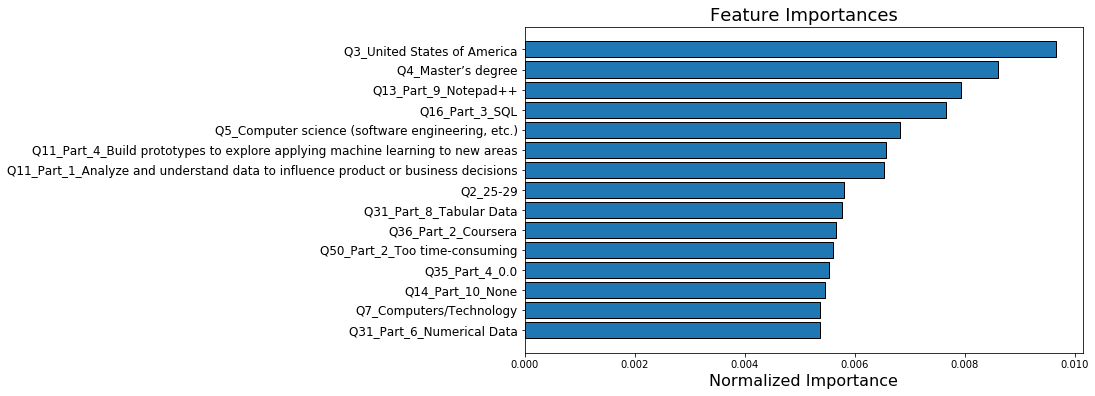

In [21]:
# Make a horizontal bar chart of feature importances
plt.figure(figsize = (10, 6))
ax = plt.subplot()

# Need to reverse the index to plot most important on top
ax.barh(list(reversed(list(feature_importances.index[:15]))), 
        feature_importances['normalized_importance'].head(15), 
        align = 'center', edgecolor = 'k')

# Set the yticks and labels
ax.set_yticks(list(reversed(list(feature_importances.index[:15]))))
ax.set_yticklabels(feature_importances['feature'].head(15), size = 12)

# Plot labeling
plt.xlabel('Normalized Importance', size = 16); plt.title('Feature Importances', size = 18)
plt.show()

#### Visualize relationships between topk(15) important features with the target(salary) - correlation

In [23]:
# extract top 15 feature's column data
top_15 = feature_importances.head(15)['feature'].values.tolist()
feature_importance_df = X_train[top_15]

# add target column
feature_importance_df['target']=y_train

# compute correlations
feature_importance_corr = feature_importance_df.corr()

E:\Applications\Anaconda3\lib\site-packages\ipykernel\__main__.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


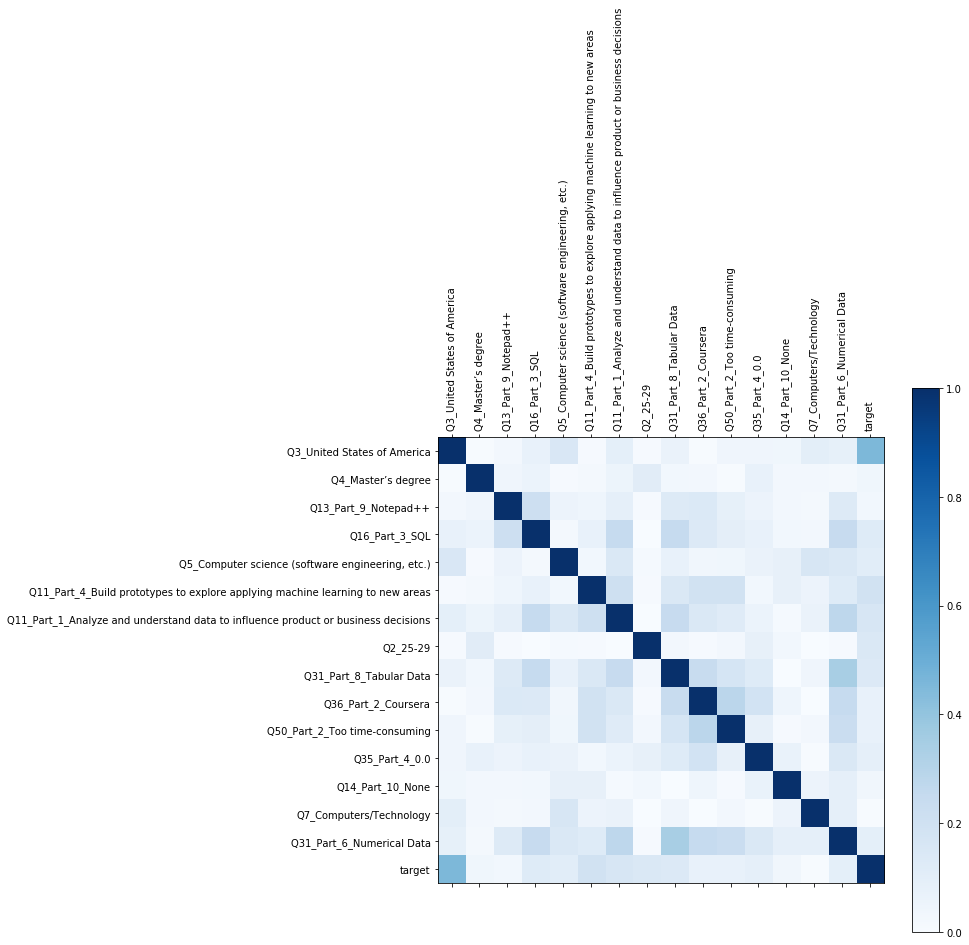

In [24]:
names = feature_importance_corr.index
correlations = feature_importance_corr.abs()
# plot correlation matrix
fig = plt.figure(figsize=(10,10))
ax = fig.add_subplot(111)
cax = ax.matshow(correlations, vmin=0, vmax=1,cmap=plt.cm.Blues)
fig.colorbar(cax)
ticks = np.arange(0,16,1)
ax.set_xticks(ticks)
ax.set_yticks(ticks)
ax.set_xticklabels(correlations.index,rotation=90)
ax.set_yticklabels(correlations.index)
plt.show()

**Noticed that some features have high correlation with each other other than with the target. In regression, "multicollinearity" refers to predictors that are correlated with other predictors.  Multicollinearity occurs when the model includes multiple factors that are correlated not just to response variable, but also to each other. In other words, it results when having factors that are a bit redundant. That will affect the R^2 performance for our regression model. So we should consider dropping high multicollinear features in the Feature Selection section.**

## 3. Feature selection

ref - https://en.wikipedia.org/wiki/Feature_engineering <br>
**"Feature engineering is the process of using domain knowledge of the data to create features that make machine learning algorithms work." By doing fearuring correctly, it increases the predictive power of machine learning algorithms by creating features from raw data that help facilitate the machine learning process.**
* **it helps capture most important features amnong raw data for trainging**
* **it helps eliminate redundant features - faster training**
* **it helps imporve overall predictive performance**

In [56]:
# reconstructure training dataframe
feature_df = X_train.join(y_train)

# calculate the whole correlation matrix
corr_matrix = feature_df.corr()

# first we need to drop the features with high correlation with each other
# Create correlation matrix
corr_matrix = corr_matrix.abs()

# Select upper triangle of correlation matrix
upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(np.bool))

# Find index of feature columns with correlation greater than 0.50
to_drop = [column for column in upper.columns if any(upper[column] > 0.5)]

**Correlated features in general don't improve models (although it depends on the specifics of the problem like the number of variables and the degree of correlation), but they affect specific models in different ways and to varying extents:**

* For linear models (e.g., linear regression or logistic regression), multicolinearity can yield solutions that are wildly varying and possibly numerically unstable.

* Random forests can be good at detecting interactions between different features, but highly correlated features can mask these interactions.


In [61]:
# we will be dropping 178 features first
len(to_drop)

178

In [62]:
X_train = X_train.drop(to_drop, axis=1)

**Now we fit the trimmed data again back to our Light Gradient boosting model to see how many top features will build up an accumulative importance of almost 100%. In the Light Gradient boosting model, each feature will be give a corresponding importance, and we can see how many features will already done contributing the model**

In [64]:
model = LGBMRegressor(n_estimators=1000, learning_rate = 0.05, verbose = -1)
model.fit(X_train, y_train)

LGBMRegressor(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
       importance_type='split', learning_rate=0.05, max_depth=-1,
       min_child_samples=20, min_child_weight=0.001, min_split_gain=0.0,
       n_estimators=1000, n_jobs=-1, num_leaves=31, objective=None,
       random_state=None, reg_alpha=0.0, reg_lambda=0.0, silent=True,
       subsample=1.0, subsample_for_bin=200000, subsample_freq=0,
       verbose=-1)

In [65]:
feature_names = list(X_train.columns)
feature_importances = pd.DataFrame({'feature': feature_names, 'importance': model.feature_importances_})

# Sort features according to importance
feature_importances = feature_importances.sort_values('importance', ascending = False).reset_index(drop = True)

# Normalize the feature importances to add up to one
feature_importances['normalized_importance'] = feature_importances['importance'] / feature_importances['importance'].sum()
feature_importances['cumulative_importance'] = np.cumsum(feature_importances['normalized_importance'])

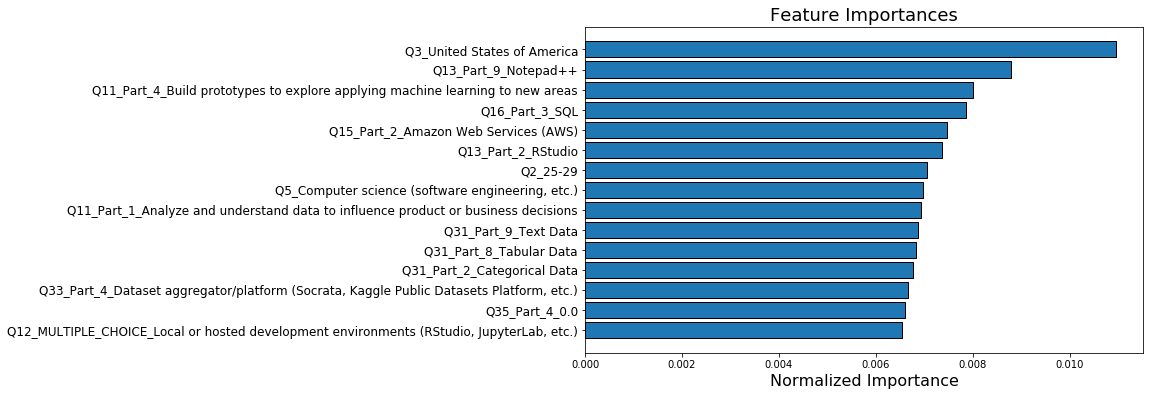

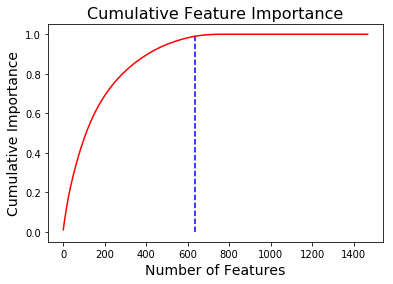

636 features required for 0.99 of cumulative importance


In [67]:
# ploting code ref - https://github.com/WillKoehrsen/feature-selector/blob/master/Feature%20Selector%20Development.ipynb
# Make a horizontal bar chart of feature importances
plt.figure(figsize = (10, 6))
ax = plt.subplot()

# Need to reverse the index to plot most important on top
ax.barh(list(reversed(list(feature_importances.index[:15]))), 
        feature_importances['normalized_importance'].head(15), 
        align = 'center', edgecolor = 'k')

# Set the yticks and labels
ax.set_yticks(list(reversed(list(feature_importances.index[:15]))))
ax.set_yticklabels(feature_importances['feature'].head(15), size = 12)

# Plot labeling
plt.xlabel('Normalized Importance', size = 16); plt.title('Feature Importances', size = 18)
plt.show()

# Cumulative importance plot
plt.figure(figsize = (6, 4))
plt.plot(list(range(1, len(feature_importances) + 1)), feature_importances['cumulative_importance'], 'r-')
plt.xlabel('Number of Features', size = 14); plt.ylabel('Cumulative Importance', size = 14) 
plt.title('Cumulative Feature Importance', size = 16)

# Index of minimum number of features needed for cumulative importance threshold
threshold = 0.99
importance_index = np.min(np.where(feature_importances['cumulative_importance'] > threshold))
plt.vlines(x = importance_index + 1, ymin = 0, ymax = 1, linestyles='--', colors = 'blue')
plt.show()

print('%d features required for %0.2f of cumulative importance' % (importance_index + 1, threshold))

**We have an idea that around 636 features(top) will build up almost 99% of the cumulative feature importance, therefore, we decide to choose top 636 important features for out modelling process.**

## 4. Model implementation

In [68]:
# select top 636 important features
X_train = X_train[feature_importances['feature'].values.tolist()[0:636]]
X_test =  X_test[feature_importances['feature'].values.tolist()[0:636]]

In [69]:
#set up cross validation
def run_kfold(model,X,Y):
 
    kf = KFold(n_splits=10) #n_splits previously n_folds
    
    outcomes = []
    fold = 0
    
    for train_index, test_index in kf.split(X):
        fold += 1
        X_train, X_test = X.values[train_index], X.values[test_index]
        Y_train, Y_test = Y.values[train_index], Y.values[test_index]
        
        model.fit(X_train, Y_train)
        predictions = model.predict(X_test)
        
        accuracy = r2_score(Y_test, predictions) # can try mean absolute error instead
        outcomes.append(accuracy)
        print("Fold {0} accuracy: {1}".format(fold, accuracy))   
        
    mean_outcome = np.mean(outcomes)
    std_outcome=np.std(outcomes)
    print("Mean r2: {0}".format(mean_outcome)) 
    print("Standard Deviation: {0}".format(std_outcome)) 

### 4.1 Gradient Boosting

**Gradient Boosting - At each iteration, gradient decent algorithm is used to fit a model to the residuals of the previous model, sequentially fit a weak leaner to the residuals of the previous model.**

* pros - can gradually reduce the bias
* cons - it sometimes takes longer to train the model since its more complex
* avg model accuracy - scored 0.593 - not bad, it has some bias.
* standard deviation - 0.01996 - pretty good, the viriance is small.
* lower variance but bias not low enough, we will compare with other models to see if bias is the best

I chose the model since it fits well for both feature selection and regression trees.


In [70]:
model_GB = LGBMRegressor()
run_kfold (model_GB,X_train,y_train)

Fold 1 accuracy: 0.5799772173863744
Fold 2 accuracy: 0.5999497166661989
Fold 3 accuracy: 0.6119615266801901
Fold 4 accuracy: 0.5816604016990155
Fold 5 accuracy: 0.6238268700865
Fold 6 accuracy: 0.607484915832698
Fold 7 accuracy: 0.5620193041759269
Fold 8 accuracy: 0.5942368837645982
Fold 9 accuracy: 0.6071348112647724
Fold 10 accuracy: 0.5620634644298197
Mean r2: 0.5930315111986093
Standard Deviation: 0.019960740734336468


### 4.2 Random Forest
**Random Forest - Uses fully grown decision trees(low bias, high variance). ensembled to use uncorrelated trees to reduce overall model variance.**

* pros - can gradually reduce the variance Pros using decorrelates trees (relative to bagged trees), but we acutally already deleted high inter-correlated features.
* cons - Not as easy to visually interpret, when tree number grows, it takes longer to train
* avg model accuracy - scored 0.5011 - lower than Gradient boosting. - make sense since it does not reduce bias
* standard deviation - 0.0249 - amazingly highter than Gradient Boosting, should not happen,we will see in the tuning.
* comparatively higher variance with higher bias not good.

I chose the model since ideally it should fits well to reduce the variance, we will see how it performs in the tuning.


In [74]:
model_RF = RandomForestRegressor()
run_kfold (model_RF,X_train,y_train)

Fold 1 accuracy: 0.466629867987838
Fold 2 accuracy: 0.5053315437994308
Fold 3 accuracy: 0.5456397300332093
Fold 4 accuracy: 0.4813464785374473
Fold 5 accuracy: 0.5266082132936742
Fold 6 accuracy: 0.5042393208203246
Fold 7 accuracy: 0.48436305859002093
Fold 8 accuracy: 0.5164017858737169
Fold 9 accuracy: 0.5151459280622928
Fold 10 accuracy: 0.46589923506356634
Mean r2: 0.5011605162061522
Standard Deviation: 0.02488217150879083


### 4.3 Lasso
**Lasso-  is a regression analysis method that performs both variable selection and regularization in order to enhance the prediction accuracy and interpretability of the statistical model it produces.**

* pros - can be used to do both feature selection and regulization, panelize large weights by forceing them with a scale.
* cons - any dimensionality reduction algorithm, it might lose some relevant independent variables along the way. And it takes so long sometimes but ends up not converging.
* avg model accuracy - scored 0.5572 - lower than Gradient boosting but better than random forest
* standard deviation - 0.0162 - amazingly lower than Gradient Boosting.

I chose the model since ideally it should fits well to reduce the bias, regulized linear regression should performs better than the baseline model, we will see how it performs in the tuning.


In [72]:
model_L = Lasso()
warnings.filterwarnings("ignore")
run_kfold (model_L,X_train,y_train)

Fold 1 accuracy: 0.5552837308315025
Fold 2 accuracy: 0.5562714516920265
Fold 3 accuracy: 0.553028158117554
Fold 4 accuracy: 0.5536869431830745
Fold 5 accuracy: 0.5707284967365409
Fold 6 accuracy: 0.557424129296241
Fold 7 accuracy: 0.5240429479587269
Fold 8 accuracy: 0.5610653672614776
Fold 9 accuracy: 0.5920539093906221
Fold 10 accuracy: 0.5483894980724321
Mean r2: 0.5571974632540199
Standard Deviation: 0.016199079060483196


### 4.4 Ridge
**Random Forest - Uses fully grown decision trees(low bias, high variance). ensembled to use uncorrelated trees to reduce overall model variance.**

* pros - has closed form solution, process much faster, will deal with Multicollinearity. Can improve predictive performance
* cons - Ridge regression is not able to shrink coefficients to exactly zero,a s a result, it cannot perform variable selection
* avg model accuracy - scored 0.5571 - same as Lasso
* standard deviation - 0.0160 - amazingly being the lowest,we will see in the tuning.

I chose the model since ideally it should fits well prevent effect of Multicollinearity, even if we have already done cleaning, Ridge should also perform well, we will see how it performs in the tuning.


In [156]:
model_R = Ridge()
run_kfold (model_R,X_train,y_train)

Fold 1 accuracy: 0.5547412563884333
Fold 2 accuracy: 0.5557904119216789
Fold 3 accuracy: 0.5522671695224393
Fold 4 accuracy: 0.5542475052177498
Fold 5 accuracy: 0.5718255198719617
Fold 6 accuracy: 0.5575483895737993
Fold 7 accuracy: 0.5242097848390823
Fold 8 accuracy: 0.5607691454736938
Fold 9 accuracy: 0.5910593724188483
Fold 10 accuracy: 0.5488596966901688
Mean r2: 0.5571318251917855
Standard Deviation: 0.016037998581828534


**So far, gradient boosting performs the best by having lowest bias and not bad variance**

|Model|Gradient Boosting|Random Forest|Lasso|Ridge|
|---|---|---|---|---|
|average accuracy(R^2)|**0.5930**|0.5011|0.5572|0.5571|
|standard deviation|0.0199|0.0249|0.0162|0.0160|

Amazingly Ridge has lower variance than Gradient Boosting.

Text(0.5, 1.0, 'Bias Virance Trade off')

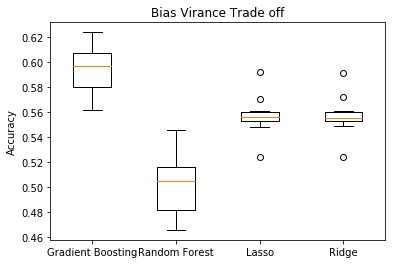

In [12]:
trade_off_dict = {'Gradient Boosting': [0.5799772173863744, 0.5999497166661989, 0.6119615266801901, 0.5816604016990155,0.6238268700865,0.607484915832698,0.5620193041759269,0.5942368837645982,0.6071348112647724,0.5620634644298197], 
                  'Random Forest': [0.466629867987838, 0.5053315437994308,0.5456397300332093,0.4813464785374473,0.5266082132936742,0.5042393208203246,0.48436305859002093,0.5164017858737169,0.5151459280622928,0.46589923506356634],
                  'Lasso': [0.5552837308315025,0.5562714516920265,0.553028158117554,0.5536869431830745,0.5707284967365409,0.557424129296241,0.5240429479587269,0.5610653672614776,0.5920539093906221,0.5483894980724321],
                  'Ridge': [0.5547412563884333,0.5557904119216789,0.5522671695224393,0.5542475052177498,0.5718255198719617,0.5575483895737993,0.5242097848390823,0.5607691454736938,0.5910593724188483,0.5488596966901688]}

fig, ax = plt.subplots()
ax.boxplot(trade_off_dict.values())
ax.set_xticklabels(trade_off_dict.keys())
plt.ylabel('Accuracy') 
plt.title('Bias Virance Trade off')

#### R-squared is a statistical measure of how close the data are to the fitted regression line. It is also known as the coefficient of determination, or the coefficient of multiple determination for multiple regression, the higher the R-squared, the better the model fits the data. <br> We can see from the boxplot that both Lasso and Ridge have low variance and Gradient Boosting is performing well with higher accuracy. And Random Forest is not performing well as it was thought to reduce variance.

## 5. Model tuning

### 5.1 Lasso
**by tuning the alpha as 4, the Lasso yields the best model with a best score of 0.5652**

In [91]:
# create and fit a ridge regression model, testing each alpha
model_L = Lasso()

#Parameters to test
parameters = {'alpha':[0.01, 0.1, 1, 4, 5, 10, 20, 50, 100], # Constant that multiplies the L1 term. Defaults to 1.0.
             'normalize':[True, False]} 

# Compare parameters by score of model 
acc_scorer = make_scorer(r2_score)

grid_L = GridSearchCV(estimator=model_L, 
                      param_grid=parameters,
                      scoring=acc_scorer)

grid_L.fit(X_train,y_train)
Lasso_grid = grid_L.best_estimator_

In [133]:
grid_L.best_score_

0.5652932067927366

In [92]:
Lasso_grid

Lasso(alpha=4, copy_X=True, fit_intercept=True, max_iter=1000, normalize=True,
   positive=False, precompute=False, random_state=None, selection='cyclic',
   tol=0.0001, warm_start=False)

### 5.2 Ridge
**by tuning the alpha as 0.15, the Ridge yields the best model with a best score of 0.5464**

In [96]:
# create and fit a ridge regression model, testing each alpha
model_R = Ridge()

#Parameters to test
parameters = {'alpha':[0.001, 0.01, 0.1, 0.15, 0.2, 0.5, 1, 5, 10, 100], # Constant that multiplies the L1 term. Defaults to 1.0.
             'normalize':[True, False]} #

# Compare parameters by score of model 
acc_scorer = make_scorer(r2_score)

grid_R = GridSearchCV(estimator=model_R, 
                      param_grid=parameters,
                      scoring=acc_scorer)

grid_R.fit(X_train,y_train)
Ridge_grid = grid_R.best_estimator_

In [134]:
grid_R.best_score_

0.5463814475614087

In [97]:
Ridge_grid

Ridge(alpha=0.15, copy_X=True, fit_intercept=True, max_iter=None,
   normalize=True, random_state=None, solver='auto', tol=0.001)

### 5.3 Random Forrest
**by tuning the number of estimators as 20, with max_features as total number, the Random Forest yields the best model with a best score of 0.5168**

In [25]:
# create and fit a ridge regression model, testing each alpha
model_RF = RandomForestRegressor()

#Parameters to test
parameters = {'max_features': ['auto',0.25, 0.5, 0.75],
              'n_estimators': [10, 20, 30, 50]} 

# Compare parameters by score of model 
acc_scorer = make_scorer(r2_score)

grid_RF = GridSearchCV(estimator=model_RF, 
                      param_grid=parameters,
                      scoring=acc_scorer)

grid_RF.fit(X_train,y_train)
RF_grid = grid_RF.best_estimator_

In [27]:
grid_RF.best_score_ 

0.5167537331393274

In [28]:
RF_grid

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=20, n_jobs=1,
           oob_score=False, random_state=None, verbose=0, warm_start=False)

### 5.4 Gradient Boosting
**by tuning the learning rate as 0.05, number of leaves as 50, number of estimators as 500, the Gradient Boosting yields the best model with a best score of 0.5876**

In [ ]:
# create and fit a ridge regression model, testing each alpha
model_GB = LGBMRegressor()

#Parameters to test
parameters = {'learning_rate': [0.05],
              'num_leaves': [50],
              'n_estimators': [500]} 

# Compare parameters by score of model 
acc_scorer = make_scorer(r2_score)

grid_GB = GridSearchCV(estimator=model_GB, 
                      param_grid=parameters,
                      scoring=acc_scorer)

grid_GB.fit(X_train,y_train)
GB_grid = grid_GB.best_estimator_

In [128]:
grid_GB.best_score_ 

0.5876493961065313

In [112]:
GB_grid

LGBMRegressor(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
       importance_type='split', learning_rate=0.05, max_depth=-1,
       min_child_samples=20, min_child_weight=0.001, min_split_gain=0.0,
       n_estimators=200, n_jobs=-1, num_leaves=50, objective=None,
       random_state=None, reg_alpha=0.0, reg_lambda=0.0, silent=True,
       subsample=1.0, subsample_for_bin=200000, subsample_freq=0)

**And Gradient Boosting performs the best after hyperparameter tunning with respect to R^2.**

|Model|Gradient Boosting|Random Forest|Lasso|Ridge|
|---|---|---|---|---|
|BEST score(R^2)|**0.5876**|0.5168|0.5653|0.5464|

## 6. Testing & Discussion

In [135]:
# we pick the optimal model with corresponding parameters and test for both train and test data.
GB_grid.fit(X_train,y_train)
GB_grid.score(X_train,y_train)

0.8717334475141297

In [136]:
GB_grid.score(X_test,y_test)

0.5968167940743341

**The optimal model after hyperparameter tunning is the Gradient Boosting with Grid-search. We pick the model and test both train and test data. The training set has an accuracy of 0.8717 however the testing dataset only yield an accuracy of 0.5968. Traning accuracy much higher than the testing accuacy, reflecting an clear overfitting problem. To fight with overfitting:**
 * early stopping - Up until a certain number of iterations, new iterations improve the model. After that point, however, the model’s ability to generalize can weaken as it begins to overfit the training data. We could top the training process before the learner passes that point.
 * Nested cross validation - when doing grid-search, we would perform more k-fold cross validation for both hyperparatmeter tuning and overall model performance.
 * collect more data (not too much as it will cause overfitting)
 * do better feature engineering
 
**Only increase the training accuracy without looking at the test accuracy is not a good idea. Traning accuracy is a description of how good the model fits for the seen data, test accuracy is the model's actual performance on unseen data. The way we might try to improve the accuracy would be:**
* neural network - thought it is not convex that might not yield global optimal but still a good try
* we could try other feature engineering methods:
  * using recursive feature selection for feature selection
  * taking the natural log of target(salary) to increase the overall predictive power but not influencing result
